# ***Introduction to DS Project - Group 01***


Part B
---

Ron Elias 313316598

Yahlly Schein 207004011

# Imports

## The kneed package is used to determine the right k (the knee point of the clustering to choose the best amount of clusters)

In [1]:
!pip install kneed

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer, silhouette_samples, davies_bouldin_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from kneed import KneeLocator
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # To ignore n_init warnings

# Load data

In [4]:
df = pd.read_csv("clustering_data.csv",index_col=0)

In [5]:
df

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10
0,-1.784220,9.139177,2.517077,-6.691300,3.332583,-6.189314,-8.294717,-5.527558,-9.150377,-3.437419
1,4.513056,-6.242134,-9.764999,8.975386,0.213133,-5.610271,6.194787,-0.247325,-1.000023,-9.091131
2,1.076570,-6.806062,-11.354346,11.589776,1.223487,-4.481565,5.119435,-0.036395,-2.308850,-5.820222
3,-0.203146,-6.098289,10.389102,-3.527880,-6.376361,3.444334,-0.331659,-3.784060,-6.922082,-3.463537
4,-4.488164,9.539276,0.414895,-3.298754,4.835677,-6.927819,-9.123490,-3.135282,-10.179017,-3.273429
...,...,...,...,...,...,...,...,...,...,...
2495,-1.946019,-5.311701,6.450032,-3.702229,-6.876948,1.629110,-3.398310,-4.534716,-6.746924,-4.928462
2496,3.688606,-9.763320,-6.745432,8.385506,-0.077451,-7.701742,4.784362,-1.560023,-1.079255,-6.833646
2497,-6.151428,-0.120076,6.293342,1.694578,-1.065751,-5.811064,-10.625511,3.157429,-3.792363,-6.793285
2498,-2.641632,8.073094,0.956380,-5.387133,4.496828,-6.396634,-9.163113,-1.719945,-10.508237,-3.756620


### We used three methods to evaluate our results:
#### 1. Silhouette:
  Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. **A score close to 1 suggests that the clusters are dense and well-separated.** Silhouette score is a more reliable metric for choosing the optimal number of clusters because it considers both cohesion and separation.
#### 2. Davies-Bouldin Index:
The average 'similarity' between clusters, where similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
**A lower Davies-Bouldin index indicates better clustering.**
#### 3.** Inertia -(metric specific to KMeans clustering):
Inertia is a measure of how internally coherent clusters are. It calculates the sum of squared distances between each data point and its centroid within a cluster. Lower inertia indicates that the clusters are tight and well-separated. However, inertia alone is not sufficient for determining the optimal number of clusters because it decreases as the number of clusters increases, tending towards zero when each data point is assigned its own cluster.


# DBScan


### This function receives the dataframe and runs DBscan.
### We used random search to find the best parameters (Epsilon and Min_points) based on the Silhouette Score metric.
### We added a silhouette scores plot a scatter plot of the first two features, and the Silhouette per cluster to visualise a little bit

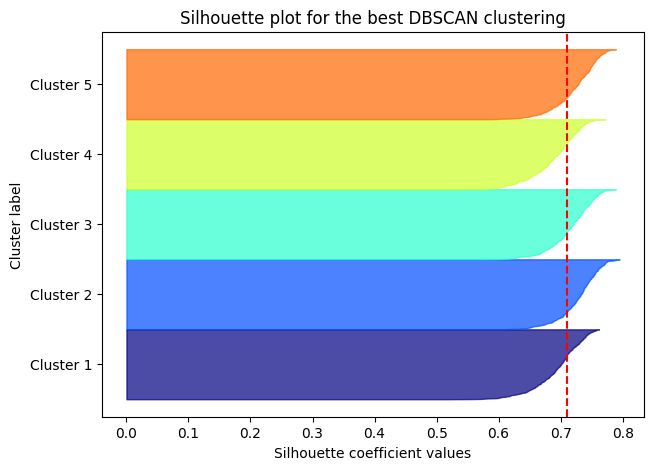

Number of Clusters: 5
Silhouette Score: 0.7100351450387195
Davies-Bouldin Score: 0.42556005962982635
Best Parameters: {'min_samples': 1, 'eps': 1.8}


In [6]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        return 0
    return silhouette_score(X, labels)

def run_dbscan_and_evaluate(df, eps=0.7, min_samples=5, random_state=42):
    new_df_db_scan = df.copy()
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(new_df_db_scan)

    # Fit DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df_scaled)

    # Visualize the clusters using a 2D scatter plot (for the first two features)
    if new_df_db_scan.shape[1] >= 2:
        fig = px.scatter(new_df_db_scan, x=new_df_db_scan.columns[0], y=new_df_db_scan.columns[1], color=labels,
                         title='DBSCAN Clustering',
                         labels={'x': new_df_db_scan.columns[0], 'y': new_df_db_scan.columns[1], 'color': 'Cluster'})
        fig.show()

    # Evaluate the model and print the results
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)  # Account for noise label (-1)
    silhouette_avg = silhouette_score(df, labels) if n_clusters > 1 else None
    davies_bouldin = davies_bouldin_score(df, labels) if n_clusters > 1 else None


    # Plotting the Silhouette Score
    fig, ax = plt.subplots(figsize=(7, 5))
    silhouette_vals = silhouette_samples(df, labels)
    y_lower, y_upper = 0, 0
    ticks = []
    for i in np.unique(labels):
        ith_cluster_silhouette_values = silhouette_vals[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper += size_cluster_i
        color = cm.jet(float(i) / len(np.unique(labels)))
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks(ticks)
    ax.set_yticklabels(['Cluster %s' % str(i+1) for i in np.unique(labels)])
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_title('Silhouette plot for the best DBSCAN clustering')
    plt.show()

    print(f"Number of Clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {davies_bouldin}")

    return labels


#We use random search for hyper parameters tuning
param_dist = {'eps': np.linspace(0.1, 2.0, 20), 'min_samples': range(1, 10)}
random_search = RandomizedSearchCV(DBSCAN(), param_distributions=param_dist, n_iter=50, scoring=silhouette_scorer, random_state=42)
random_search.fit(df)
best_params = random_search.best_params_

# Now, run DBSCAN with the best parameters and evaluate
labels = run_dbscan_and_evaluate(df, eps=best_params['eps'], min_samples=best_params['min_samples'], random_state=42)
print("Best Parameters:", best_params)

#Kmeans


### This function receives a dataframe and runs KMeans on it.

### We use the kneed package to extract the best K (that's how we find the optimal hyperparameter K).
### We can see in the plots we added that there are most likely 5 clusters

In [8]:
def run_kmeans_and_evaluate(df):
    new_df = df.copy()
    features = df.columns

    # Choose a range of k values to evaluate
    k_values = range(2, 11)

    # Initialize lists to store the results
    inertia_values = []
    silhouette_scores = []
    davies_bouldin_scores = []

    # Iterate over different k values
    for k in k_values:
        # Fit KMeans model
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(new_df)

        # Append inertia (within-cluster sum of squares) to list
        inertia_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(new_df, kmeans.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(new_df, labels))

    # Plot the elbow curve to determine the optimal k
    fig = px.line(x=np.arange(2, 11), y=inertia_values, labels={'x': 'Number of Clusters (k)', 'y': 'Inertia'},
                  title='Elbow Method - Inertia')
    fig.show()

    # Plot silhouette scores if there are at least 2 clusters
    if len(silhouette_scores) > 0:
        fig = px.line(x=np.arange(2, 11), y=silhouette_scores, labels={'x': 'Number of Clusters (k)', 'y': 'Silhouette Score'},
                      title='Silhouette Score')
        fig.show()


    # Choose the optimal k based on the elbow method
    print(f"Inertia Values:{inertia_values}")
    optimal_k = np.argmin(np.diff(inertia_values)) + 2  # +2 because of 0-based indexing
    knee_locator = KneeLocator(k_values, inertia_values, curve='convex', direction='decreasing')
    optimal_k = knee_locator.knee
    # Fit KMeans model with the optimal k
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    final_kmeans.fit(new_df)

    # Add cluster labels to the original DataFrame
    new_df['Kmeans_Cluster'] = final_kmeans.labels_

    # Evaluate the model and print the results
    silhouette_avg = silhouette_score(df, final_kmeans.labels_)
    davies_bouldin_final = davies_bouldin_score(df, final_kmeans.labels_)
    print(f"Optimal Number of Clusters (k): {optimal_k}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {davies_bouldin_final}")
    # Visualize the clusters using a 2D scatter plot (for the first two features)
    if new_df.shape[1] >= 2:
        fig = px.scatter(new_df, x=features[0], y=features[1], color='Kmeans_Cluster',
                         title='KMeans Clustering',
                         labels={'x': features[0], 'y': features[1], 'color': 'Kmeans_Cluster'})
        fig.show()

    return new_df


clustered_df = run_kmeans_and_evaluate(df)


Inertia Values:[329752.64045478206, 220530.47147137366, 119474.05548606417, 41926.002527649674, 41236.37927763724, 40483.0141323653, 39775.55595983245, 39141.02752538599, 38636.53430447013]
Optimal Number of Clusters (k): 5
Silhouette Score: 0.7100351450387195
Davies-Bouldin Score: 0.42556005962982646


# Evaluation and comparison between the models

In [10]:
clustered_df["db_scan_labels"] = labels
clustered_df

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,Kmeans_Cluster,db_scan_labels
0,-1.784220,9.139177,2.517077,-6.691300,3.332583,-6.189314,-8.294717,-5.527558,-9.150377,-3.437419,4,0
1,4.513056,-6.242134,-9.764999,8.975386,0.213133,-5.610271,6.194787,-0.247325,-1.000023,-9.091131,0,1
2,1.076570,-6.806062,-11.354346,11.589776,1.223487,-4.481565,5.119435,-0.036395,-2.308850,-5.820222,0,1
3,-0.203146,-6.098289,10.389102,-3.527880,-6.376361,3.444334,-0.331659,-3.784060,-6.922082,-3.463537,3,2
4,-4.488164,9.539276,0.414895,-3.298754,4.835677,-6.927819,-9.123490,-3.135282,-10.179017,-3.273429,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.946019,-5.311701,6.450032,-3.702229,-6.876948,1.629110,-3.398310,-4.534716,-6.746924,-4.928462,3,2
2496,3.688606,-9.763320,-6.745432,8.385506,-0.077451,-7.701742,4.784362,-1.560023,-1.079255,-6.833646,0,1
2497,-6.151428,-0.120076,6.293342,1.694578,-1.065751,-5.811064,-10.625511,3.157429,-3.792363,-6.793285,1,3
2498,-2.641632,8.073094,0.956380,-5.387133,4.496828,-6.396634,-9.163113,-1.719945,-10.508237,-3.756620,4,0


In [11]:
db_scan_lbls = clustered_df["db_scan_labels"]
knn_lbls = clustered_df["Kmeans_Cluster"]

In [12]:
silhouette_score(df, db_scan_lbls), davies_bouldin_score(df, db_scan_lbls)

(0.7100351450387195, 0.42556005962982635)

In [13]:
silhouette_score(df, knn_lbls), davies_bouldin_score(df, knn_lbls)

(0.7100351450387195, 0.42556005962982646)

In [14]:
clustered_df["db_scan_labels"].value_counts()

db_scan_labels
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64

In [15]:
clustered_df["Kmeans_Cluster"].value_counts()

Kmeans_Cluster
4    500
0    500
3    500
1    500
2    500
Name: count, dtype: int64

In [16]:
import sklearn.metrics
sklearn.metrics.adjusted_rand_score(clustered_df["Kmeans_Cluster"], clustered_df["db_scan_labels"])

1.0

#### Both models clustered the data into 5 clusters
#### The division of points is the same (Both models have 500 datapoints in each cluster)

### **DBScan:**
#### Silhouette Score: 0.7100351450387195
#### Davies-Bouldin Score: 0.42556005962982635


### **KMEANS:**
#### Silhouette Score: 0.7100351450387195
#### Davies-Bouldin Score: 0.42556005962982635


## -
# Best parameters:
DBScan:

*   Min_samples = 1
*   Epsilon = 1.8


Kmeans:

*   K = 5


#### Notice that both models got the same results.
#### We could have ran  KMeans more times with different randomised starting points so there are higher chances of getting the global optimum, and better results (No guarantee of optimum).



# Using PCA, reducing dimentionality and plotting the results:

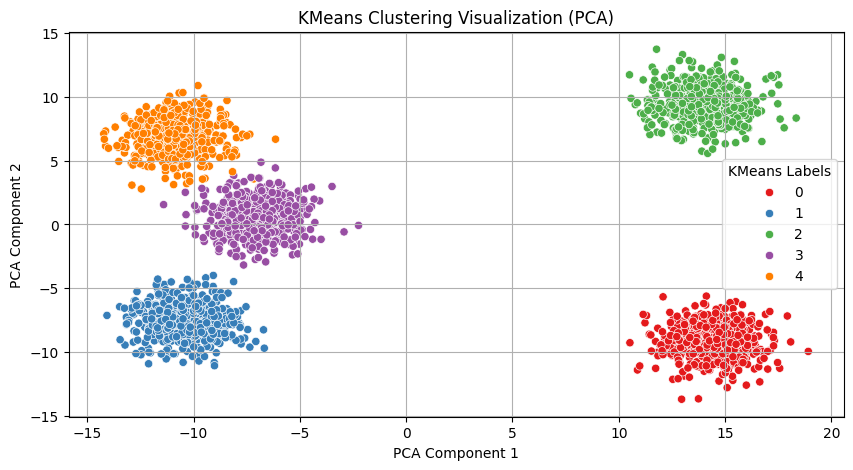

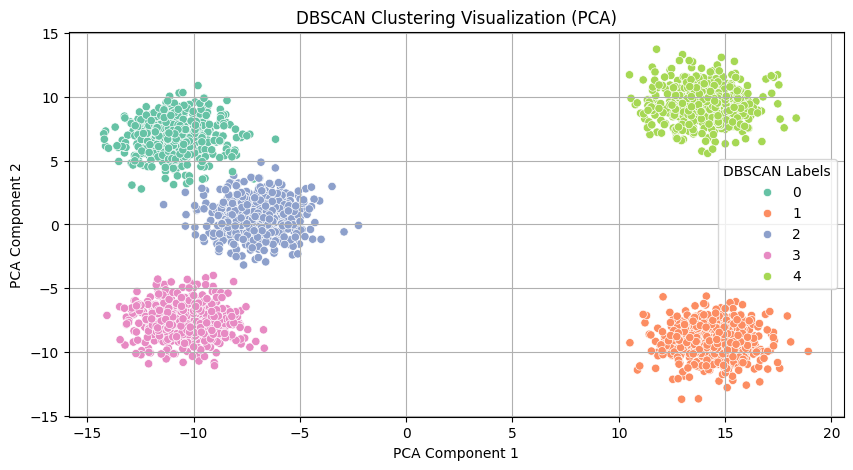

In [19]:
# Extract
X = df  # Assuming column names for labels are 'KMeans_Labels' and 'DBSCAN_Labels'

# Initialize PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(X)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA_1', 'PCA_2'])

pca_df['Kmeans_Cluster'] = clustered_df['Kmeans_Cluster']
pca_df['db_scan_labels'] = clustered_df['db_scan_labels']

# Plotting KMeans
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Kmeans_Cluster', data=pca_df, palette='Set1')
plt.title('KMeans Clustering Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='KMeans Labels')
plt.grid(True)
plt.show()

# Plotting DBSCAN
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='db_scan_labels', data=pca_df, palette='Set2')
plt.title('DBSCAN Clustering Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='DBSCAN Labels')
plt.grid(True)
plt.show()
